In [1]:
# Imports
import csv
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas
import pandas as pd
import requests
import json
import scipy.stats as st
from scipy.stats import linregress

# Import API key
from config import geoapify_key

# Read in CSV file
filepath = "cost_of_living_us.csv"
data = pd.read_csv(filepath)
df = pd.DataFrame(data)
df.head()

,case_id,state,isMetro,areaname,county,family_member_count,housing_cost,food_cost,transportation_cost,healthcare_cost,other_necessities_cost,childcare_cost,taxes,total_cost,median_family_income
0,1,AL,True,"Montgomery, AL MSA",Autauga County,1p0c,8505.72876,3454.91712,10829.16876,5737.47984,4333.81344,0.0000,6392.94504,39254.0532,73010.414062
1,1,AL,True,"Montgomery, AL MSA",Autauga County,1p1c,12067.50240,5091.70788,11588.19288,8659.55640,6217.45896,6147.8298,7422.07836,57194.3256,73010.414062
2,1,AL,True,"Montgomery, AL MSA",Autauga County,1p2c,12067.50240,7460.20308,12361.77720,11581.63260,7075.65816,15824.6940,9769.56228,76141.0308,73010.414062
3,1,AL,True,"Montgomery, AL MSA",Autauga County,1p3c,15257.15040,9952.23924,13452.18600,14503.70760,9134.35620,18802.1892,13101.70320,94203.5328,73010.414062
4,1,AL,True,"Montgomery, AL MSA",Autauga County,1p4c,15257.15040,12182.21400,13744.59840,17425.78560,9942.36396,18802.1892,13469.21880,100823.5200,73010.414062


In [2]:
# Drop data from other states, only include Ohio data (temporary)
#df = df.loc[df["state"] == "OH"]
df.head()

,case_id,state,isMetro,areaname,county,family_member_count,housing_cost,food_cost,transportation_cost,healthcare_cost,other_necessities_cost,childcare_cost,taxes,total_cost,median_family_income
0,1,AL,True,"Montgomery, AL MSA",Autauga County,1p0c,8505.72876,3454.91712,10829.16876,5737.47984,4333.81344,0.0000,6392.94504,39254.0532,73010.414062
1,1,AL,True,"Montgomery, AL MSA",Autauga County,1p1c,12067.50240,5091.70788,11588.19288,8659.55640,6217.45896,6147.8298,7422.07836,57194.3256,73010.414062
2,1,AL,True,"Montgomery, AL MSA",Autauga County,1p2c,12067.50240,7460.20308,12361.77720,11581.63260,7075.65816,15824.6940,9769.56228,76141.0308,73010.414062
3,1,AL,True,"Montgomery, AL MSA",Autauga County,1p3c,15257.15040,9952.23924,13452.18600,14503.70760,9134.35620,18802.1892,13101.70320,94203.5328,73010.414062
4,1,AL,True,"Montgomery, AL MSA",Autauga County,1p4c,15257.15040,12182.21400,13744.59840,17425.78560,9942.36396,18802.1892,13469.21880,100823.5200,73010.414062


In [3]:
# Clean dataframe
df = df.rename(columns={"case_id": "Case ID",
                        "state": "State",
                        "isMetro": "Metro",
                        "areaname": "Area Name",
                        "county": "County",
                        "family_member_count": "Number of Adults/Children",
                        "housing_cost": "Housing Cost",
                        "food_cost": "Food Cost",
                        "transportation_cost": "Transportation Cost",
                        "healthcare_cost": "Healthcare Cost",
                        "other_necessities_cost": "Other Necessities Cost",
                        "childcare_cost": "Childcare Cost",
                        "taxes": "Taxes",
                        "total_cost": "Total Cost",
                        "median_family_income": "Median Income"})
df.head()

,Case ID,State,Metro,Area Name,County,Number of Adults/Children,Housing Cost,Food Cost,Transportation Cost,Healthcare Cost,Other Necessities Cost,Childcare Cost,Taxes,Total Cost,Median Income
0,1,AL,True,"Montgomery, AL MSA",Autauga County,1p0c,8505.72876,3454.91712,10829.16876,5737.47984,4333.81344,0.0000,6392.94504,39254.0532,73010.414062
1,1,AL,True,"Montgomery, AL MSA",Autauga County,1p1c,12067.50240,5091.70788,11588.19288,8659.55640,6217.45896,6147.8298,7422.07836,57194.3256,73010.414062
2,1,AL,True,"Montgomery, AL MSA",Autauga County,1p2c,12067.50240,7460.20308,12361.77720,11581.63260,7075.65816,15824.6940,9769.56228,76141.0308,73010.414062
3,1,AL,True,"Montgomery, AL MSA",Autauga County,1p3c,15257.15040,9952.23924,13452.18600,14503.70760,9134.35620,18802.1892,13101.70320,94203.5328,73010.414062
4,1,AL,True,"Montgomery, AL MSA",Autauga County,1p4c,15257.15040,12182.21400,13744.59840,17425.78560,9942.36396,18802.1892,13469.21880,100823.5200,73010.414062


In [4]:
# Group by metro/rural
df_Metro = df.groupby("Metro").mean(numeric_only=True)
df_Metro.drop(columns=["Case ID"],inplace=True)
# Separate into two dataframes
df_Costs = df_Metro.drop(columns=["Total Cost","Median Income"])
df_Totals = df_Metro[["Total Cost","Median Income"]]
df_Metro.head()

,Housing Cost,Food Cost,Transportation Cost,Healthcare Cost,Other Necessities Cost,Childcare Cost,Taxes,Total Cost,Median Income
Metro,,,,,,,,,
False,9895.308705,8165.377513,13721.750019,13707.946043,6544.098883,8729.840612,6823.694820,67588.016584,62826.026868
True,13060.779367,8493.450419,13378.186169,12864.670291,7809.947489,11818.425399,9064.143316,76489.602427,77581.789236


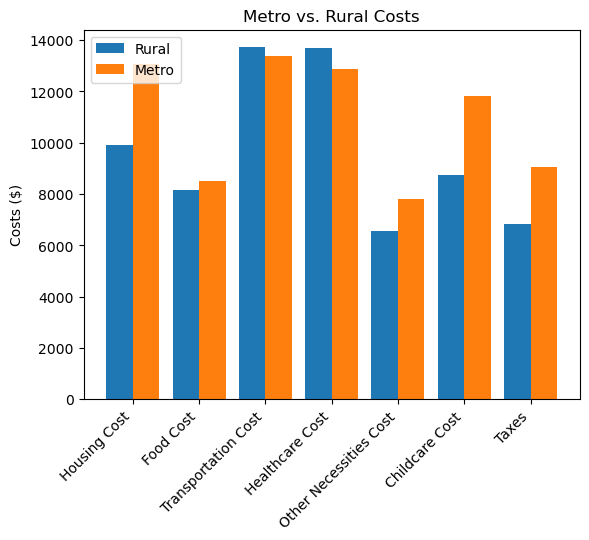

In [5]:
# Plot cost breakdown
rural_data = df_Costs.iloc[0]
metro_data = df_Costs.iloc[1]
x_axis = np.arange(len(rural_data.index))
width = 0.4
plt.bar(x_axis-width/2,rural_data,width=width,label="Rural")
plt.bar(x_axis+width/2,metro_data,width=width,label="Metro")
plt.title("Metro vs. Rural Costs")
plt.legend(loc='upper left')
plt.xticks(np.arange(0,7,step=1),df_Costs.columns,rotation=45,ha='right')
plt.ylabel("Costs ($)")
plt.show()

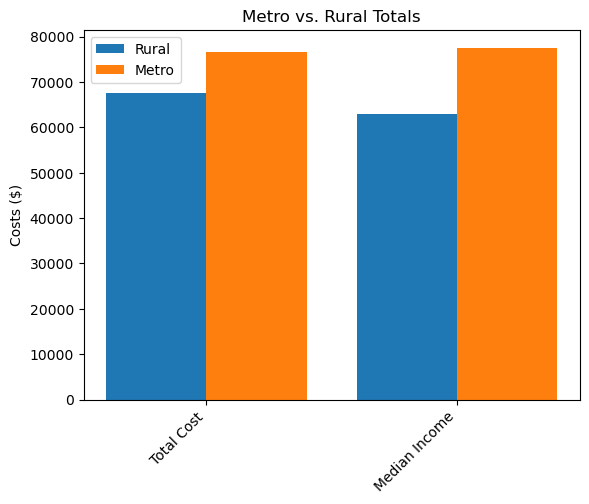

In [6]:
# Plot total costs and median incomes
rural_data = df_Totals.iloc[0]
metro_data = df_Totals.iloc[1]
x_axis = np.arange(len(rural_data.index))
plt.bar(x_axis-width/2,rural_data,width=width,label="Rural")
plt.bar(x_axis+width/2,metro_data,width=width,label="Metro")
plt.title("Metro vs. Rural Totals")
plt.legend(loc='upper left')
plt.xticks(np.arange(0,2,step=1),df_Totals.columns,rotation=45,ha='right')
plt.ylabel("Costs ($)")
plt.show()

In [7]:
# Reformat # of Adults/Children column
adults = df["Number of Adults/Children"].str[0]
children = df["Number of Adults/Children"].str[2]
total_residents = adults.astype(int) + children.astype(int)
# Add data into separate new columns
df.insert(6,"Adults",adults.astype(int),True)
df.insert(7,"Children",children.astype(int),True)
df.insert(8,"Total Residents",total_residents,True)
df.head(10)

,Case ID,State,Metro,Area Name,County,Number of Adults/Children,Adults,Children,Total Residents,Housing Cost,Food Cost,Transportation Cost,Healthcare Cost,Other Necessities Cost,Childcare Cost,Taxes,Total Cost,Median Income
0,1,AL,True,"Montgomery, AL MSA",Autauga County,1p0c,1,0,1,8505.72876,3454.91712,10829.16876,5737.47984,4333.81344,0.0000,6392.94504,39254.0532,73010.414062
1,1,AL,True,"Montgomery, AL MSA",Autauga County,1p1c,1,1,2,12067.50240,5091.70788,11588.19288,8659.55640,6217.45896,6147.8298,7422.07836,57194.3256,73010.414062
2,1,AL,True,"Montgomery, AL MSA",Autauga County,1p2c,1,2,3,12067.50240,7460.20308,12361.77720,11581.63260,7075.65816,15824.6940,9769.56228,76141.0308,73010.414062
3,1,AL,True,"Montgomery, AL MSA",Autauga County,1p3c,1,3,4,15257.15040,9952.23924,13452.18600,14503.70760,9134.35620,18802.1892,13101.70320,94203.5328,73010.414062
4,1,AL,True,"Montgomery, AL MSA",Autauga County,1p4c,1,4,5,15257.15040,12182.21400,13744.59840,17425.78560,9942.36396,18802.1892,13469.21880,100823.5200,73010.414062
5,1,AL,True,"Montgomery, AL MSA",Autauga County,2p0c,2,0,2,10180.29420,6334.01436,12861.88680,11474.95968,5983.78524,0.0000,8236.73076,55071.6684,73010.414062
6,1,AL,True,"Montgomery, AL MSA",Autauga County,2p1c,2,1,3,12067.50240,7883.31888,13589.11200,14397.03720,7228.96944,6147.8298,9459.90240,70773.6744,73010.414062
7,1,AL,True,"Montgomery, AL MSA",Autauga County,2p2c,2,2,4,12067.50240,9984.05268,14723.60760,17319.11280,7990.14840,15824.6940,11168.75028,89077.8696,73010.414062
8,1,AL,True,"Montgomery, AL MSA",Autauga County,2p3c,2,3,5,15257.15040,12189.77040,14994.60000,20241.18720,9945.10176,18802.1892,13210.14840,104640.1524,73010.414062
9,1,AL,True,"Montgomery, AL MSA",Autauga County,2p4c,2,4,6,15257.15040,14917.35840,15064.26360,23163.26520,10933.41504,18802.1892,13417.21920,111554.8596,73010.414062


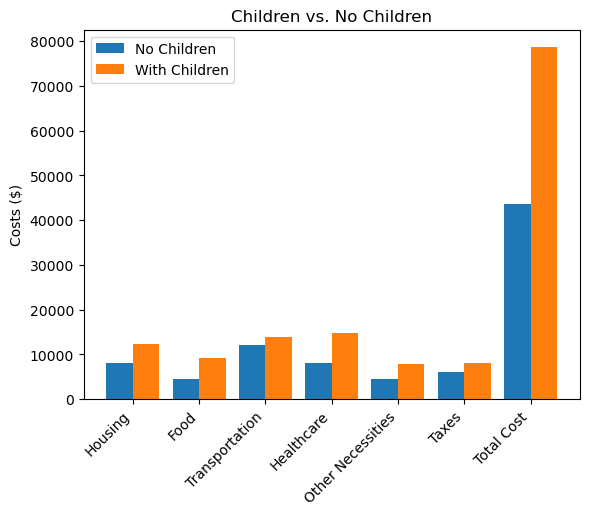

In [8]:
# Separate dataframe into children and no children
df_noChildren = df.loc[df["Children"] == 0]
df_withChildren = df.loc[df["Children"] != 0]
# Group by county and take averages of relevant columns
df_noChildren = df_noChildren.groupby("County").mean(numeric_only=True)
noChildren_data = [df_noChildren["Housing Cost"].mean(),
                   df_noChildren["Food Cost"].mean(),
                   df_noChildren["Transportation Cost"].mean(),
                   df_noChildren["Healthcare Cost"].mean(),
                   df_noChildren["Other Necessities Cost"].mean(),
                   df_noChildren["Taxes"].mean(),
                   df_noChildren["Total Cost"].mean()]
df_withChildren = df_withChildren.groupby("County").mean(numeric_only=True)
withChildren_data = [df_withChildren["Housing Cost"].mean(),
                     df_withChildren["Food Cost"].mean(),
                     df_withChildren["Transportation Cost"].mean(),
                     df_withChildren["Healthcare Cost"].mean(),
                     df_withChildren["Other Necessities Cost"].mean(),
                     df_withChildren["Taxes"].mean(),
                     df_withChildren["Total Cost"].mean()]
# Plot
x_axis = np.arange(0,len(noChildren_data),step=1)
plt.bar(x_axis-width/2,noChildren_data,width=width,label="No Children")
plt.bar(x_axis+width/2,withChildren_data,width=width,label="With Children")
plt.title("Children vs. No Children")
plt.legend(loc='upper left')
labels = ["Housing","Food","Transportation","Healthcare","Other Necessities","Taxes","Total Cost"]
plt.xticks(np.arange(0,len(noChildren_data),step=1),labels,rotation=45,ha='right')
plt.ylabel("Costs ($)")
plt.show()

In [9]:
# Group data by state and county
df_temp = df.set_index(['State','County'])
df_county = df_temp.groupby(level=[0,1]).mean(numeric_only=True)
df_county.drop(columns=["Case ID","Metro","Adults","Children","Total Residents"],inplace=True)
df_county.head()

Housing Cost     Food Cost  \
State County                                                   
AK    Aleutians East Borough           13972.8   9558.261408   
      Aleutians West Census Area       19893.6  14205.249132   
      Anchorage Municipality           16400.4   8214.818772   
      Bethel Census Area               20449.2   9007.670412   
      Bristol Bay Borough              14144.4   8435.054736   

                                  Transportation Cost  Healthcare Cost  \
State County                                                             
AK    Aleutians East Borough              7418.068608     15934.691412   
      Aleutians West Census Area          3461.726124     15934.691412   
      Anchorage Municipality             13453.207068     15018.749448   
      Bethel Census Area                 10841.219724     15246.419364   
      Bristol Bay Borough                15171.583680     15934.691412   

                                  Other Necessities Cost  Childcare Cost  \
State County                                                               
AK    Aleutians East Borough                 8526.231408    14066.399688   
      Aleutians West Census Area            12355.358004    17090.006400   
      Anchorage Municipality                 8919.064380    18216.542400   
      Bethel Census Area                    10673.385624    16918.296432   
      Bristol Bay Borough                    8181.426696    14157.811992   

                                         Taxes   Total Cost  Median Income  
State County                                                                
AK    Aleutians East Borough       7177.323252  76653.77676   79776.171875  
      Aleutians West Census Area  11116.614720  94057.24488   98061.890625  
      Anchorage Municipality      10309.730592  90532.51272  104803.000000  
      Bethel Census Area          11034.683880  94170.87576   55433.203125  
      Bristol Bay Borough          8893.329324  84918.29796  100848.695312

In [81]:
# Find most and least expensive counties in each state
max_cost = df_county.loc[df_county.groupby(level=[0])["Total Cost"].idxmax()]
min_cost = df_county.loc[df_county.groupby(level=[0])["Total Cost"].idxmin()]
# Find average cost of living, average income, and taxes in each state
mean_cost = df_county.groupby(level=[0])["Total Cost"].mean()
mean_cost = pd.DataFrame(mean_cost)
mean_income = df_county.groupby(level=[0])["Median Income"].mean()
mean_income = pd.DataFrame(mean_income)
taxes = df_county.groupby(level=[0])["Taxes"].mean()
taxes = pd.DataFrame(taxes)

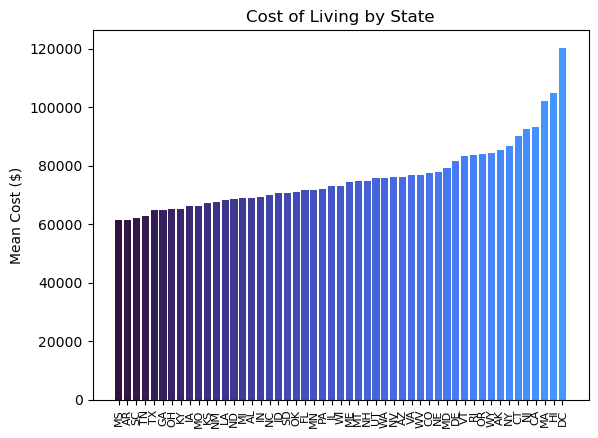

In [111]:
# Plot mean cost of living by state
mean_cost.sort_values(by=["Total Cost"],inplace=True)
colormap = plt.get_cmap("turbo")
plt.bar(mean_cost.index,mean_cost['Total Cost'],color=colormap.colors)
plt.xticks(rotation=90,ha='center',fontsize=8)
plt.title("Cost of Living by State")
plt.ylabel("Mean Cost ($)")
plt.show()

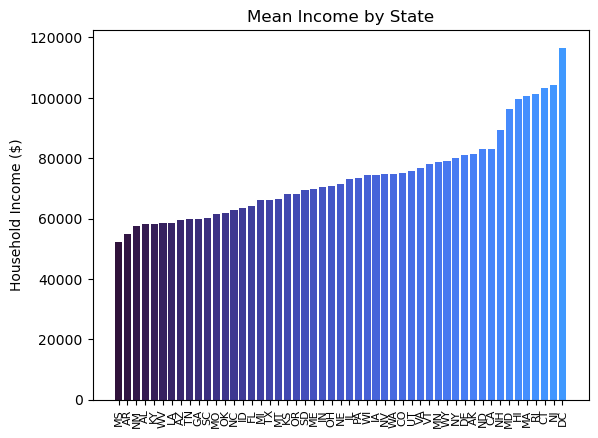

In [112]:
# Plot mean income by state
mean_income.sort_values(by=["Median Income"],inplace=True)
plt.bar(mean_income.index,mean_income['Median Income'],color=colormap.colors)
plt.xticks(rotation=90,ha='center',fontsize=8)
plt.title("Mean Income by State")
plt.ylabel("Household Income ($)")
plt.show()

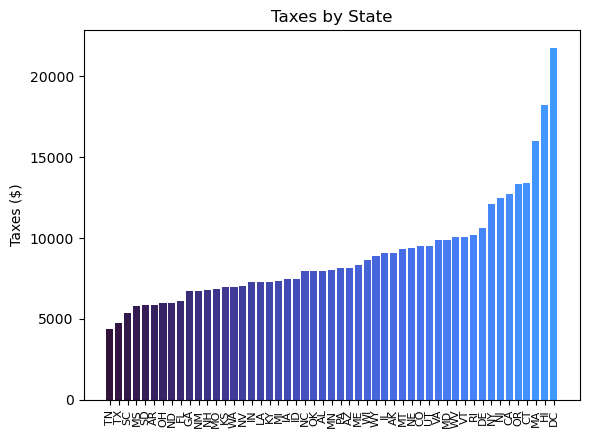

In [113]:
# Plot taxes by state
taxes.sort_values(by=["Taxes"],inplace=True)
plt.bar(taxes.index,taxes['Taxes'],color=colormap.colors)
plt.xticks(rotation=90,ha='center',fontsize=8)
plt.title("Taxes by State")
plt.ylabel("Taxes ($)")
plt.show()

In [34]:
# Begin GeoAPIfy stuff
base_url = "https://api.geoapify.com/v1/geocode/search?state="
# Go state by state and find geographic centers for plotting
df_coordinates = pd.DataFrame(columns=['State','Latitude','Longitude'])
state_names = ["Alaska", "Alabama", "Arkansas", "Arizona", "California", "Colorado", "Connecticut", "District of Columbia", "Delaware", "Florida", "Georgia", "Hawaii", "Iowa", "Idaho", "Illinois", "Indiana", "Kansas", "Kentucky", "Louisiana", "Massachusetts", "Maryland", "Maine", "Michigan", "Minnesota", "Missouri", "Mississippi", "Montana", "North Carolina", "North Dakota", "Nebraska", "New Hampshire", "New Jersey", "New Mexico", "Nevada", "New York", "Ohio", "Oklahoma", "Oregon", "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah", "Virginia", "Vermont", "Washington", "Wisconsin", "West Virginia", "Wyoming"]
for state in state_names:
    # Make request
    url = base_url + state + "&type=state&limit=1&apiKey=" + geoapify_key
    response = requests.get(url)
    data = response.json()
    # Pull data from json and add to dataframe
    latitude = data['features'][0]['geometry']['coordinates'][1]
    longitude = data['features'][0]['geometry']['coordinates'][0]
    print(f"State: {state}, Coordinates: {latitude},{longitude}")
    new_row = {'State':state,'Latitude':latitude,'Longitude':longitude}
    df_coordinates = pd.concat([df_coordinates, pd.DataFrame([new_row])],ignore_index=True)
df_coordinates

State: Alaska, Coordinates: 64.4459613,-149.680909
State: Alabama, Coordinates: 33.2588817,-86.8295337
State: Arkansas, Coordinates: 35.2048883,-92.4479108
State: Arizona, Coordinates: 34.395342,-111.763275
State: California, Coordinates: 36.7014631,-118.755997
State: Colorado, Coordinates: 38.7251776,-105.607716
State: Connecticut, Coordinates: 41.6500201,-72.7342163
State: District of Columbia, Coordinates: 38.89384735,-76.98804281910948
State: Delaware, Coordinates: 38.6920451,-75.4013315
State: Florida, Coordinates: 27.7567667,-81.4639835
State: Georgia, Coordinates: 32.3293809,-83.1137366
State: Hawaii, Coordinates: 19.593801499999998,-155.42837009716908
State: Iowa, Coordinates: 41.9216734,-93.3122705
State: Idaho, Coordinates: 43.6447642,-114.015407
State: Illinois, Coordinates: 40.0796606,-89.4337288
State: Indiana, Coordinates: 40.3270127,-86.1746933
State: Kansas, Coordinates: 38.27312,-98.5821872
State: Kentucky, Coordinates: 37.5726028,-85.1551411
State: Louisiana, Coordina

,State,Latitude,Longitude
0,Alaska,64.445961,-149.680909
1,Alabama,33.258882,-86.829534
2,Arkansas,35.204888,-92.447911
3,Arizona,34.395342,-111.763275
4,California,36.701463,-118.755997
5,Colorado,38.725178,-105.607716
6,Connecticut,41.650020,-72.734216
7,District of Columbia,38.893847,-76.988043
8,Delaware,38.692045,-75.401331
9,Florida,27.756767,-81.463983


In [58]:
# Create new dataframe for mapping
mean_cost.reset_index(inplace=True)
mean_cost.drop(columns=["State"],inplace=True)
df_map = df_coordinates.merge(mean_cost,left_index=True,right_index=True)
df_map.set_index("State",inplace=True)
df_map.head()

,Latitude,Longitude,Total Cost
State,,,
Alaska,64.445961,-149.680909,85234.557360
Alabama,33.258882,-86.829534,68967.570020
Arkansas,35.204888,-92.447911,61491.891851
Arizona,34.395342,-111.763275,75985.939376
California,36.701463,-118.755997,93179.163060
Colorado,38.725178,-105.607716,77595.782964
Connecticut,41.650020,-72.734216,90013.504620
District of Columbia,38.893847,-76.988043,120289.636920
Delaware,38.692045,-75.401331,81505.517560


In [65]:
# Configure plot
map_plot_1 = df_map.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    tiles = "OSM",
    size = 100,
    color = "Total Cost",
    hover_cols=["State","Total Cost"],
    cmap="RdYlGn_r")

# Display the map plot
map_plot_1

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Total Cost,State)

In [104]:
# Create second plot without D.C. outlier
df_map2 = df_map.drop(index='District of Columbia')
map_plot_2 = df_map2.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    tiles = "OSM",
    size = 200,
    color = "Total Cost",
    hover_cols=["State","Total Cost"],
    cmap="RdYlGn_r")

# Display the map plot
map_plot_2

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Total Cost,State)

In [100]:
# Repeat process for just Ohio
# Get data for Ohio counties
df_Ohio = df_county.loc["OH"]
# Change url for county search
base_url = "https://api.geoapify.com/v1/geocode/search?text="
df_Ohio_coordinates = pd.DataFrame(columns=['County','Latitude','Longitude'])
for county in df_Ohio.index:
    # Make request
    url = base_url + county + "&type=locality&state=Ohio&limit=1&apiKey=" + geoapify_key
    response = requests.get(url)
    data = response.json()
    # Pull data from json and add to dataframe
    latitude = data['features'][0]['geometry']['coordinates'][1]
    longitude = data['features'][0]['geometry']['coordinates'][0]
    print(f"County: {county}, Coordinates: {latitude},{longitude}")
    new_row = {'County':county,'Latitude':latitude,'Longitude':longitude}
    df_Ohio_coordinates = pd.concat([df_Ohio_coordinates, pd.DataFrame([new_row])],ignore_index=True)
df_Ohio_coordinates

County: Adams County, Coordinates: 38.8398935,-83.5051704
County: Allen County, Coordinates: 40.8077797,-84.0572225
County: Ashland County, Coordinates: 40.7887367,-82.2360391
County: Ashtabula County, Coordinates: 41.7167229,-80.74947
County: Athens County, Coordinates: 39.355589,-82.0610404
County: Auglaize County, Coordinates: 40.5942186,-84.2641951
County: Belmont County, Coordinates: 40.0057737,-81.0097516
County: Brown County, Coordinates: 38.9092542,-83.8836555
County: Butler County, Coordinates: 39.4233043,-84.5936897
County: Carroll County, Coordinates: 40.5250362,-81.0927234
County: Champaign County, Coordinates: 40.1726987,-83.7701999
County: Clark County, Coordinates: 39.9229676,-83.7905959
County: Clermont County, Coordinates: 39.0678155,-84.1566341
County: Clinton County, Coordinates: 39.4259873,-83.8445792
County: Columbiana County, Coordinates: 40.7787016,-80.7648602
County: Coshocton County, Coordinates: 40.2905684,-81.9271441
County: Crawford County, Coordinates: 40.8

,County,Latitude,Longitude
0,Adams County,38.839894,-83.505170
1,Allen County,40.807780,-84.057222
2,Ashland County,40.788737,-82.236039
3,Ashtabula County,41.716723,-80.749470
4,Athens County,39.355589,-82.061040
...,...,...,...
83,Washington County,39.478264,-81.548895
84,Wayne County,40.861582,-81.903462
85,Williams County,41.501822,-84.592378
86,Wood County,41.277666,-83.664303


In [103]:
# Calculate mean cost of living for each county
Ohio_mean_cost = df_Ohio.groupby(level=[0])["Total Cost"].mean()
Ohio_mean_cost = pd.DataFrame(Ohio_mean_cost)
Ohio_mean_cost.reset_index(inplace=True)
Ohio_mean_cost.drop(columns=["County"],inplace=True)
# Merge dataframes
df_Ohio_map = df_Ohio_coordinates.merge(Ohio_mean_cost,left_index=True,right_index=True)
df_Ohio_map.set_index("County",inplace=True)
df_Ohio_map

# Configure plot
map_plot_3 = df_Ohio_map.hvplot.points(
    "Longitude",
    "Latitude",
    geo = True,
    tiles = "OSM",
    size = 250,
    color = "Total Cost",
    hover_cols=["County","Total Cost"],
    cmap="RdYlGn_r")

# Display the map plot
map_plot_3

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Total Cost,County)